# Imports

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initalisation

In [80]:
input_size, output_size = 1024, 8
num_samples = 10000
input_data = torch.rand(num_samples, input_size)
target_data = torch.rand(num_samples, output_size)
loss_normal = list()
loss_skip = list()

In [68]:
def train_model(model, epochs, input_data, target_data, criterion, optimizer, print_every = 10):
    losses = list()
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        outputs = model(input_data)
        loss = criterion(outputs, target_data)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            
    return losses

In [75]:
def plot_loss(losses_normal, losses_skip):
    plt.figure(figsize=(8, 5))
    
    plt.plot(range(1, len(losses_normal) + 1), losses_normal, label="Noraml")
    plt.plot(range(1, len(losses_skip) + 1), losses_skip, label="Skip")
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.grid(True)
    plt.show()

# Normal Model(without skip-connection)

In [69]:
class NormalNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NormalNet, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_5 = nn.Linear(64, 32)
        self.layer_6 = nn.Linear(32, 16)
        self.layer_7 = nn.Linear(16, output_size)
        
    def forward(self, X):
        X = F.relu(self.layer_1(X))
        X = F.relu(self.layer_2(X))
        X = F.relu(self.layer_3(X))
        X = F.relu(self.layer_4(X))
        X = F.relu(self.layer_5(X))
        X = F.relu(self.layer_6(X))
        X = self.layer_7(X)
        
        return X

In [70]:
model = NormalNet(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

In [71]:
loss_normal = train_model(model, 1000, input_data, target_data, criterion, optimizer, 100)

Epoch [100/1000], Loss: 0.2160
Epoch [200/1000], Loss: 0.1421
Epoch [300/1000], Loss: 0.1066
Epoch [400/1000], Loss: 0.0914
Epoch [500/1000], Loss: 0.0858
Epoch [600/1000], Loss: 0.0839
Epoch [700/1000], Loss: 0.0833
Epoch [800/1000], Loss: 0.0831
Epoch [900/1000], Loss: 0.0830
Epoch [1000/1000], Loss: 0.0830


# Skip Model(with skip-connection)

In [72]:
class SkipNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SkipNN, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, 512)        
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_5 = nn.Linear(64, 32)
        self.layer_6 = nn.Linear(32, 16)
        self.layer_7 = nn.Linear(16, output_size)
        
    def forward(self, X):
        X1 = F.relu(self.layer_1(X))
        X2 = F.relu(self.layer_2(X1)) + X1
        X3 = F.relu(self.layer_3(X2)) + X1
        X4 = F.relu(self.layer_4(X3)) + X1
        X5 = F.relu(self.layer_5(X4)) + X1
        X6 = F.relu(self.layer_6(X5)) + X1
        X7 = self.layer_7(X6)
        
        return X7

In [73]:
skip_model = NormalNet(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(skip_model.parameters(), lr=.01)

In [74]:
loss_skip = train_model(skip_model, 1000, input_data, target_data, criterion, optimizer, 100)

Epoch [100/1000], Loss: 0.1938
Epoch [200/1000], Loss: 0.1363
Epoch [300/1000], Loss: 0.1065
Epoch [400/1000], Loss: 0.0925
Epoch [500/1000], Loss: 0.0866
Epoch [600/1000], Loss: 0.0843
Epoch [700/1000], Loss: 0.0835
Epoch [800/1000], Loss: 0.0832
Epoch [900/1000], Loss: 0.0831
Epoch [1000/1000], Loss: 0.0830


# Analysis

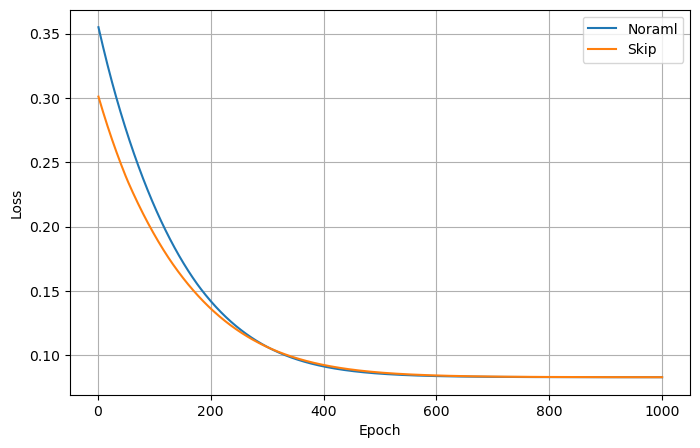

In [79]:
plot_loss(loss_normal, loss_skip)